**Train-Valid:** 2011-2019  
**Test:** 2020 and 2021

In [1]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.2.1
!pip install scikeras

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 29.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Packages & Data

In [2]:
import sys
import os
import numpy as np
import pandas as pd
# import calendar
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,metrics
import tensorflow.keras.backend as K
from keras.optimizers import Adam
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM,GRU,Conv1D,Conv2D,Flatten,Input,ConvLSTM1D,ConvLSTM2D,Dropout,BatchNormalization
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV,RandomizedSearchCV
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.constraints import MaxNorm
from sklearn.model_selection import train_test_split

from collections import Counter, defaultdict
import pickle
seed=42


In [3]:
print(tf.config.list_physical_devices())


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.keras.utils.set_random_seed(seed)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# importing data and helper functions from directories dependent on which is available

joseph_path = '/content/drive/My Drive/DS_Modules/CA4021 (Final Year Project)/' # Joseph
julita_path = '/content/drive/My Drive/CA4021 (Final Year Project)/' # Julita

if os.path.exists(joseph_path):
  print("Importing from DS_Modules/CA4021")
  sys.path.append(os.path.join(joseph_path, 'scripts'))
  path = joseph_path

elif os.path.exists(julita_path):
  print("Importing directly from CA4021 folder")
  sys.path.append(sys.path.append(os.path.join(julita_path, 'scripts')))
  path = julita_path



Importing from DS_Modules/CA4021


In [7]:
# import helper functions from aux file (prevents too much function definitions in the notebook)
from aux_functions import missing_percentages, plot_dist_discrete, plot_dist_continuous, \
plot_vis_discrete, plot_vis_continuous, month_vplot

from aux_functions_ml import preprocess, manual_cross_validate, get_feat_importance_df, \
performance_report, calc_mean_importance, plot_importance, heidke_skill_score,score_model

# import train/valid and test sets
df_train = pd.read_csv(os.path.join(path,'data/train_data.csv'))
df_train.index=pd.to_datetime(df_train.date_time)
df_train.date_time = df_train.index

df_test = pd.read_csv(os.path.join(path,'data/test_data.csv'))
df_test.index=pd.to_datetime(df_test.date_time)
df_test.date_time = df_test.index

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print("Train/valid:", df_train.shape)
print("Test:", df_test.shape)

Train/valid: (78888, 57)
Test: (17544, 57)


In [8]:
# LEAVING OUT w, ww, pweather and weather because of OH encoding sparsity

metadata = ['date', 'date_time', 'year', 'month', 'day', 'hour', 'season']
indicator = [col for col in df_train.columns if col[0] == 'i']
constant = [var for var in df_train.columns if len(df_train[var].value_counts()) == 1]
codes = ['sp1', 'sp2', 'sp3', 'sp4', 'wwa', 'wa', 'w' ,'ww', 'pweather', 'weather']
excluded = indicator + constant + codes + ['rgauge', 'sog', 'tabspeed', 'msl']
vis_vars=['target_hr1', 'vis_hr1', 'fog_formation', 'fog_dissipation', 'transition']
target = 'target_hr1'

categorical=['fog_state', 'season', 'tsig1', 'tsig2', 'tsig3', 'pchar'] #'w', 'ww', 'pweather',
             #'weather']
discrete = [var for var in df_train.columns if len(df_train[var].unique()) < 15 and 
             var not in excluded + categorical + metadata + codes + indicator + vis_vars]

continuous = [var for var in df_train.columns if var not in discrete + excluded + categorical + metadata + codes + indicator + vis_vars]
numerical = discrete+continuous
# conservative list of variables known to have an impact on fog formation.
# the other lists are too big for certain visualisations
fog_vars = ['rainfall', 'drybulb', 'cbl', 'ntot', 'dni', 'dewpt', 'speed', 'dir', 'rh']
# selected variables from XGBoost notebook
vars_sel = ['vis', 'temp_dew_dist', 'rh', 'ceiling', 'duration', 'hsig2', 'dni', 
                  'dewpt', 'drybulb', 'cbl', 'hlc', 'ntot', 'speed', 'vp', 'pchar','dir']
num_vars_sel = [var for var in vars_sel if var in discrete+continuous]
cat_vars_sel = [var for var in vars_sel if var in categorical]

dates = df_train.date_time
X = df_train[numerical + categorical + vis_vars].reset_index(drop=True)
y = X.pop(target)

# create train and test from X, without including df_test
pre_X_train, pre_X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.23, shuffle=False, random_state=seed)

# creating training sets using only the selected features
X_train, X_valid = preprocess(pre_X_train, pre_X_valid, cat_vars=cat_vars_sel, num_vars=num_vars_sel)

# create training data using all the variables df_train (for comparison)
X_train_all, X_test_all = preprocess(pre_X_train, pre_X_valid, cat_vars=categorical, num_vars=numerical)

In [9]:
pre_X_valid.head()

,clow,cmedium,chigh,nlc,ntot,nsig1,nsig2,nsig3,nsig4,tsig4,duration,sunshine,dir,speed,vis,ptend,cbl,drybulb,wetbulb,dewpt,vp,rh,hlc,hsig1,hsig2,hsig3,hsig4,ceiling,dos,rainfall,tabdir,dni,temp_dew_dist,rainfall12hma,fog_state,season,tsig1,tsig2,tsig3,pchar,vis_hr1,fog_formation,fog_dissipation,transition
60743,5.0,0.0,0.0,7,7,1,7.0,0.0,0.0,0.0,0.0,0.0,22,8,25000,1.7,1017.6,8.7,7.3,5.7,9.1,81,18,18,32.0,0.0,0.0,32,0.0,0.0,22,0,3.0,-8.881784e-15,no fog,winter,7,6.0,0.0,6,25000.0,0,0,0
60744,5.0,0.0,0.0,7,7,1,7.0,0.0,0.0,0.0,0.0,0.0,21,11,25000,1.6,1017.1,9.0,7.5,5.8,9.2,80,18,18,32.0,0.0,0.0,32,0.0,0.0,22,0,3.2,-8.881784e-15,no fog,winter,7,6.0,0.0,6,25000.0,0,0,0
60745,5.0,0.0,0.0,7,7,1,7.0,0.0,0.0,0.0,0.0,0.0,20,8,25000,1.7,1016.4,9.5,7.8,5.9,9.2,78,18,18,30.0,0.0,0.0,30,0.0,0.0,20,0,3.6,-8.881784e-15,no fog,winter,7,6.0,0.0,8,25000.0,0,0,0
60746,5.0,0.0,0.0,7,7,1,7.0,0.0,0.0,0.0,0.0,0.0,21,10,25000,2.0,1015.6,9.8,8.0,6.0,9.3,77,18,18,30.0,0.0,0.0,30,0.0,0.0,21,0,3.8,-8.881784e-15,no fog,winter,7,6.0,0.0,8,25000.0,0,0,0
60747,5.0,0.0,0.0,7,7,1,7.0,0.0,0.0,0.0,0.0,0.0,22,12,25000,2.3,1014.8,9.8,8.0,6.0,9.3,77,18,18,32.0,0.0,0.0,32,0.0,0.0,22,0,3.8,-8.881784e-15,no fog,winter,7,6.0,0.0,8,25000.0,0,0,0


In [10]:
X_valid.head()

,vis,temp_dew_dist,rh,ceiling,duration,hsig2,dni,dewpt,drybulb,cbl,hlc,ntot,speed,vp,dir,pchar_0,pchar_1,pchar_2,pchar_3,pchar_4,pchar_5,pchar_6,pchar_7,pchar_8
60743,-0.269299,-0.004030,-0.135296,-0.284854,-0.412199,-0.266548,-0.858595,-0.256145,-0.229161,1.212983,-0.103304,0.587607,-0.514436,-0.391955,0.159183,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60744,-0.269299,0.082432,-0.220337,-0.284854,-0.412199,-0.266548,-0.858595,-0.233127,-0.167896,1.171003,-0.103304,0.587607,0.016999,-0.358727,0.037891,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60745,-0.269299,0.255354,-0.390417,-0.314434,-0.412199,-0.296772,-0.858595,-0.210110,-0.065788,1.112230,-0.103304,0.587607,-0.514436,-0.358727,-0.083400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
60746,-0.269299,0.341816,-0.475458,-0.314434,-0.412199,-0.296772,-0.858595,-0.187092,-0.004524,1.045061,-0.103304,0.587607,-0.160146,-0.325499,0.037891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
60747,-0.269299,0.341816,-0.475458,-0.284854,-0.412199,-0.266548,-0.858595,-0.187092,-0.004524,0.977891,-0.103304,0.587607,0.194144,-0.325499,0.159183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
# for compatibility with TimeSeriesSplit
pre_X_train = pre_X_train.reset_index(drop=True)
pre_X_valid = pre_X_valid.reset_index(drop=True)

X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)

In [12]:
# find indices of transitions, and the index right before it
pre_X_valid[target] = y_valid
t_indices = pre_X_valid.loc[pre_X_valid['transition']==1].index
before_t_indices = t_indices - 1
t_indices = t_indices.append(before_t_indices)

# check if transition indices actually show fog state transitions
# the transition index should be 1 when there is a transition in the next hour, since we're predicting fog in the next hour
print(pre_X_valid.loc[t_indices[0]-2:t_indices[0]+2, ['fog_state', 'target_hr1', 'transition']])

    fog_state  target_hr1  transition
358    no fog           0           0
359    no fog           0           0
360    no fog           1           1
361       fog           1           0
362       fog           0           1


In [13]:
def data_preprocessing_sequences(X_or,Y_or,seq):
    inst = X_or.shape[0]
    feats = X_or.shape[1]

    X_seq = np.zeros((inst - seq+1, seq, feats))

    # the first sequence consists of the first 5 data points, and it moves up as a sliding window
    for i in range(0, inst-seq+1):
        for j in range(0, seq):
            X_seq[i, j, :] = X_or.iloc[j+i, :]
    y_seq = Y_or[seq-1:]



    # Should be included due to erroneuos tensfor transformation
    X_seq = np.asarray(X_seq).astype(np.float32)
    y_seq = np.asarray(y_seq).astype(np.float32)

    return X_seq,y_seq

def errors_classification(Y_test, Y_pred, transitions=False, transition_pos = []):

    from sklearn.metrics import f1_score,recall_score,precision_score

    f1 = f1_score(Y_test, Y_pred)*100
    hss = heidke_skill_score(Y_test, Y_pred)

    if transitions:
      Y_pred_transition = Y_pred[transition_pos]
      Y_test_transition = Y_test[transition_pos]
      
      t_f1 = f1_score(Y_test_transition, Y_pred_transition)*100
      t_hss = heidke_skill_score(Y_test_transition, Y_pred_transition)

      # only looking at transition HSS and raw F1 at the momemnt
      print('F1:{}\nTransition F1:{}\nHSS:{}\nTransition HSS:{}'.format(np.round(f1,2), 
                                                                          np.round(t_f1,2),
                                                                          np.round(hss,4),
                                                                          np.round(t_hss,4)))    

      return f1, t_f1, hss, t_hss 
    else:
      print('F1_score:{}\nHSS:{}'.format(np.round(f1, 2), np.round(hss, 8)))

      return f1, hss


In [14]:
#Data preprocessing - Create sequences as input to LSTM
seq=5
X_train_seq, y_train_seq = data_preprocessing_sequences(X_train,y_train,seq)
X_valid_seq, y_valid_seq = data_preprocessing_sequences(X_valid,y_valid,seq)

In [15]:
print("Getting transision indices from {}th to {}th sequence of validation set".format(seq, X_valid.shape[0]-seq+1))

Getting transision indices from 5th to 18141th sequence of validation set


In [16]:
# get transition indices for scoring
assert pre_X_valid.iloc[:, -2].name == 'transition'

# the first index here is the 5th record, which is the last record of the first training sequence
# hence, the t_indices matches up with the transition indices in y_valid_seq
xv_transitions = pre_X_valid.iloc[4:, -2].reset_index(drop=True)
xv_transitions.reset_index(drop=True)


# transition indices for all the sequences in the training set.
t_indices = xv_transitions[xv_transitions==1].index
before_t_indices = t_indices - 1
t_indices = t_indices.append(before_t_indices)

In [17]:
# check that t_indices positions actually correspond to transitions
#print(pre_X_valid.iloc[4:, :].reset_index().loc[t_indices[0]-1:t_indices[0]+2, ['fog_state', 'transition']])

## Testing models

Messing with hyperparameters manually.

Notes:
- Any more than two LSTM layers leads to training failure more often.
- The training loss tends to decrease smoothly, so batch sizes don't need to be increased.
- Batch normalisation didn't improve the models. We already do this in our preprocess anyways, and the training loss is not jumpy.
- Dropout didn't improve the model performance, most likely since the model is not overfitting.

In [18]:
Method='LSTM'  # 'RNN' / 'LSTM' / 'GRU' 

# Hyperparameter selection
neurons=[256,128] #[256,128]                                
patience=30
batch=100
epochs=30
loss='binary_crossentropy'
act='relu' #'relu'/'selu'/'elu'/'sigmoid'/'tanh'
seq=5
dens_neu=[32, 16] #[32,16] 

export_name = 'LSTM_model_test'

In [19]:
X_train_seq.shape

(60739, 5, 24)

In [20]:
n_timesteps = X_train_seq.shape[1]

n_features  = X_train_seq.shape[2]

input_shape=(n_timesteps,n_features)

In [21]:
# try setting parmaters directly
tf.keras.backend.clear_session() 
tf.keras.utils.set_random_seed(seed)
#tf.config.experimental.enable_op_determinism()  # performance takes a big hit in this case, but results are deterministic.

model = keras.Sequential([
    LSTM(units=256, input_shape=input_shape, return_sequences=True),
    LSTM(units=128, input_shape=input_shape, return_sequences=False),
  #  Dropout(0.2),
    Dense(units=32, activation='relu'),
   # Dropout(0.2),
    Dense(units=16, activation='relu'),
    Dense(1, activation='sigmoid')
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 256)            287744    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 489,537
Trainable params: 489,537
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Model Creation
tf.keras.backend.clear_session() 
tf.keras.utils.set_random_seed(seed)
#tf.config.experimental.enable_op_determinism()

model = keras.Sequential()


if Method=='RNN':
    Layer_type=SimpleRNN
elif Method=='LSTM':
    Layer_type=LSTM
elif Method=='GRU':
    Layer_type=GRU

n_timesteps = X_train_seq.shape[1]

n_features  = X_train_seq.shape[2]

input_shape=(n_timesteps,n_features)
print(input_shape)
for i in enumerate(neurons):
    if i[0]==len(neurons)-1:
        model.add(Layer_type(units=i[1],input_shape=input_shape,return_sequences=False))   
    else:
        model.add(Layer_type(units=i[1],input_shape=input_shape,return_sequences=True))     

for i in enumerate(dens_neu):
    model.add(keras.layers.Dense(i[1], activation=act))


model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

(5, 24)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 256)            287744    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 489,537
Trainable params: 489,537
Non-trainable params: 0
_________________________________________________________________


so far best: learning_rate=0.01, decay=0.00003
(this is with neurons = [256,128] and dens_neu = [32]
Recall:0.45
Precision:0.46
F1_score:0.45

Epoch 1/30
486/486 [==============================] - 11s 8ms/step - loss: 0.0635 - val_loss: 0.0464
Epoch 2/30
486/486 [==============================] - 3s 6ms/step - loss: 0.0335 - val_loss: 0.0242
Epoch 3/30
486/486 [==============================] - 3s 6ms/step - loss: 0.0294 - val_loss: 0.0214
Epoch 4/30
486/486 [==============================] - 5s 9ms/step - loss: 0.0265 - val_loss: 0.0245
Epoch 5/30
486/486 [==============================] - 4s 7ms/step - loss: 0.0246 - val_loss: 0.0195
Epoch 6/30
486/486 [==============================] - 3s 6ms/step - loss: 0.0231 - val_loss: 0.0193
Epoch 7/30
486/486 [==============================] - 3s 7ms/step - loss: 0.0222 - val_loss: 0.0242
Epoch 8/30
486/486 [==============================] - 4s 8ms/step - loss: 0.0218 - val_loss: 0.0191
Epoch 9/30
486/486 [==============================] - 3s 6ms/step - loss: 0.0203 - val_loss: 0.0184
Epoch 10/30
486/486 [==============================] - 3s 6ms/step - loss: 0.0196 - val_loss: 0.018

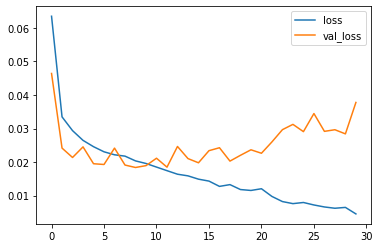

In [23]:
#Best model so far is here

#Compile Model
model.compile(loss=loss, optimizer=Adam(learning_rate=0.001, decay=0.00003))
#model.compile(loss=loss, optimizer='adam')
#Train Model

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
history = model.fit(verbose = 1,
                        x = X_train_seq,
                        y = y_train_seq,
                        batch_size=batch,
                        epochs=epochs,     
                        validation_split=0.2,
                        #validation_data=(X_valid_seq, y_valid_seq),
                        shuffle=False,
                        validation_steps=None,
                        validation_freq=1,
                        workers=4,
                        use_multiprocessing=False,
                        callbacks=[callback]
                        )

# print loss curve
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));


# Save Model
model.save(export_name)


In [24]:
  # Test Prediction
# incosistent results with each run, for final evaluation on the test set we should retrain
# the model several times
y_pred=model.predict(X_valid_seq).round()

f1, t_f1, hss, t_hss = errors_classification(y_valid_seq, y_pred, transitions=True, transition_pos=t_indices)

567/567 [==============================] - 3s 3ms/step
F1:25.26
Transition F1:11.21
HSS:0.2489
Transition HSS:-0.0556


In [189]:
from collections import Counter

Counter(y_pred.ravel())

Counter({0.0: 18096, 1.0: 45})

In [142]:
Counter(y_valid_seq.ravel())

Counter({0.0: 18022, 1.0: 119})

## Grid Search (Done in paperspace)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)


# Function to create model, required for KerasClassifier
def create_model(neurons,dens_neu):
 # create model
 model = Sequential()
 for i in enumerate(neurons):
    if i[0]==len(neurons)-1:
        model.add(LSTM(units=i[1],input_shape=(5,24),return_sequences=False))   
    else:
        model.add(LSTM(units=i[1],input_shape=(5,24),return_sequences=True))     


 for i in enumerate(dens_neu):
    model.add(keras.layers.Dense(i[1], activation='relu'))

 model.add(keras.layers.Dense(1, activation='sigmoid'))
 # Compile model
 model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01, decay=0.00003),metrics=[keras.metrics.Precision(), keras.metrics.Recall()])
 return model


In [ ]:
# Best result for LSTM (previous)
grid_result.best_params_

{'model__neurons': (256, 128),
 'epochs': 10,
 'dens_neu': (32, 16),
 'batch_size': 200}

In [ ]:

# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)
time_split = TimeSeriesSplit(n_splits = 5)
# create model
model = KerasClassifier(model=create_model, dens_neu=(32,32),callbacks=[callback])
# define the grid search parameters
batch_size = [100]
epochs = [50] 
dens_neu=[(32,32),(32)]
# to try : dens_neu=[(64),(64,32)]
neurons = [(256,128),(256,128,64),(256,64),(512,128)]
param_grid = dict(model__neurons=neurons,batch_size=batch_size, epochs=epochs,dens_neu=dens_neu)
grid = GridSearchCV(model,param_grid,cv=time_split,return_train_score=True,scoring='f1')
grid_result = grid.fit(X_train, Y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/50
132/132 [==============================] - 9s 7ms/step - loss: 0.0470 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/50
132/132 [==============================] - 1s 7ms/step - loss: 0.0282 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/50
132/132 [==============================] - 1s 6ms/step - loss: 0.0254 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/50
132/132 [==============================] - 1s 6ms/step - loss: 0.0222 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/50
132/132 [==============================] - 1s 7ms/step - loss: 0.0218 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/50
132/132 [==============================] - 1s 9ms/step - loss: 0.0182 - precision: 0.6000 - recall: 0.0341
Epoch 7/50
132/132 [==============================] - 2s 12ms/step - loss: 0.0182 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 8/50
132/132 [==============================] - 1s 9ms/step - loss: 0.0144 - precision: 0.8000 - recall: 0.0909
Epoch 9

In [ ]:
grid_result.cv_results_

{'mean_fit_time': array([44.14404402]),
 'std_fit_time': array([13.93237914]),
 'mean_score_time': array([1.42029948]),
 'std_score_time': array([0.45208499]),
 'param_batch_size': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_dens_neu': masked_array(data=[(32, 16)],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_epochs': masked_array(data=[10],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_model__neurons': masked_array(data=[(256, 64)],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'batch_size': 100,
   'dens_neu': (32, 16),
   'epochs': 10,
   'model__neurons': (256, 64)}],
 'split0_test_score': array([0.99148095]),
 'split1_test_score': array([0.9876778]),
 'split2_test_score': array([0.99368677]),
 'split3_test_score': array([0.99323039]),
 'split4_test_score': array([0.99520803]),
 'mean

## Final Evaluation

*X_train_f* contains entire df_train dataset. It contains the training and validation data and differs from *X_train*, which is a subset of *df_train*.

Since the Keras neural nets converge differently each time, we meed to train the model a number of times and compute the means of the different scores.

In [32]:
n_reruns = 10

In [26]:
# Create trian and test sets from df_train and df_test
X_train_f, X_test = preprocess(df_train, df_test, cat_vars=cat_vars_sel, num_vars=num_vars_sel)

y_train_f = df_train[target]
y_test = df_test[target]

#Data preprocessing - Create sequences as input to LSTM
seq=5
X_train_f_seq, y_train_f_seq = data_preprocessing_sequences(X_train_f, y_train_f, seq)
X_test_seq, y_test_seq = data_preprocessing_sequences(X_test, y_test, seq)

# storing scores from repeated LSTM model trainings
fm_scores=defaultdict(list)

In [27]:
# get transition indices for scoring
assert df_test.iloc[:, -1].name == 'transition'


# the first index here is the 5th record, which is the last record of the first training sequence
# hence, the t_indices matches up with the transition indices in y_valid_seq
xv_transitions = df_test.iloc[4:, -1].reset_index(drop=True)
xv_transitions.reset_index(drop=True)

# transition indices for all the sequences in the training set.
t_indices_test = xv_transitions[xv_transitions==1].index
before_t_indices = t_indices_test - 1
t_indices_test = t_indices_test.append(before_t_indices)

so far best: learning_rate=0.01, decay=0.00003
(this is with neurons = [256,128] and dens_neu = [32]
Recall:0.45
Precision:0.46
F1_score:0.45

In [49]:
Method='LSTM'  # 'RNN' / 'LSTM' / 'GRU' 

# Hyperparameter selection
neurons=[256,128] #[256,128]                                
patience=30
batch=100
epochs=30
loss='binary_crossentropy'
act='relu' #'relu'/'selu'/'elu'/'sigmoid'/'tanh'
seq=5
dens_neu=[32, 16] #[32,16] 
learning_rate = 0.001

params = {}
params['neurons'] = neurons
params['dense_neurons'] = dens_neu
params['patience'] = patience
params['batch_size'] = batch
params['epochs'] = epochs
params['loss'] = loss
params['activation'] = act
params['seq_length'] = seq
params['learning_rate'] = learning_rate

Training Model no 1
Minimum Validation Loss: 0.0175


549/549 [==============================] - 2s 3ms/step
F1:37.92
Transition F1:26.49
HSS:0.3744
Transition HSS:-0.0673
----------------------------------------------------------------------------------------------------

Training Model no 2
Minimum Validation Loss: 0.0175


549/549 [==============================] - 3s 3ms/step
F1:41.46
Transition F1:28.77
HSS:0.4107
Transition HSS:0.0
----------------------------------------------------------------------------------------------------

Training Model no 3
Minimum Validation Loss: 0.0175


549/549 [==============================] - 2s 2ms/step
F1:42.76
Transition F1:29.14
HSS:0.4228
Transition HSS:-0.0288
----------------------------------------------------------------------------------------------------

Training Model no 4
Minimum Validation Loss: 0.0175


549/549 [==============================] - 2s 2ms/step
F1:41.67
Transition F1:30.14
HSS:0.4118
Transition HSS:0.0192
----------------------------------------------------------------------------------------------------

Training Model no 5
Minimum Validation Loss: 0.0175


549/549 [==============================] - 2s 3ms/step
F1:40.45
Transition F1:28.97
HSS:0.4
Transition HSS:0.0096
----------------------------------------------------------------------------------------------------

Training Model no 6
Minimum Validation Loss: 0.0175


549/549 [==============================] - 2s 2ms/step
F1:37.23
Transition F1:35.14
HSS:0.3674
Transition HSS:0.0769
----------------------------------------------------------------------------------------------------

Training Model no 7
Minimum Validation Loss: 0.0175


549/549 [==============================] - 2s 3ms/step
F1:40.0
Transition F1:26.95
HSS:0.3957
Transition HSS:0.0096
----------------------------------------------------------------------------------------------------

Training Model no 8
Minimum Validation Loss: 0.0175


549/549 [==============================] - 2s 2ms/step
F1:45.43
Transition F1:33.99
HSS:0.4493
Transition HSS:0.0288
----------------------------------------------------------------------------------------------------

Training Model no 9
Minimum Validation Loss: 0.0175


549/549 [==============================] - 2s 2ms/step
F1:37.45
Transition F1:24.83
HSS:0.3701
Transition HSS:-0.0481
----------------------------------------------------------------------------------------------------

Training Model no 10
Minimum Validation Loss: 0.0175


549/549 [==============================] - 2s 2ms/step
F1:35.25
Transition F1:26.39
HSS:0.3474
Transition HSS:-0.0192
----------------------------------------------------------------------------------------------------



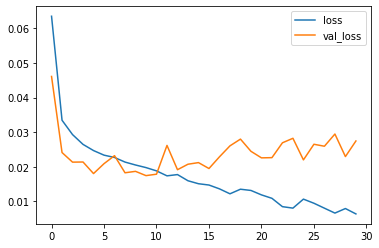

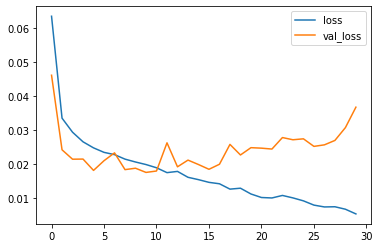

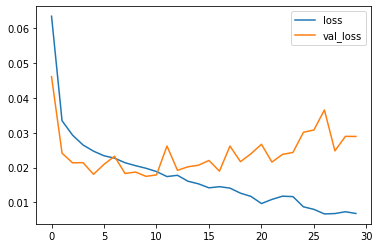

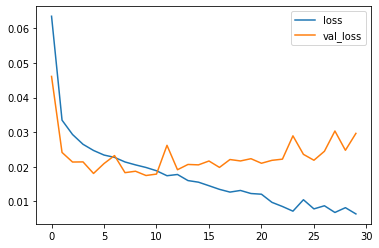

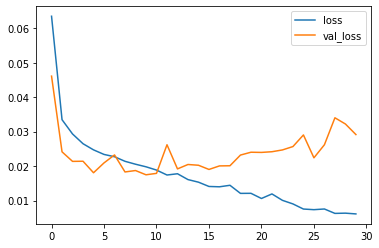

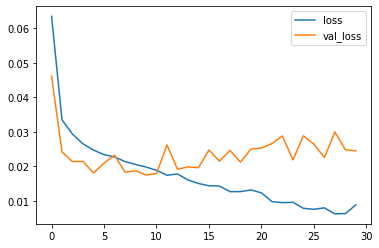

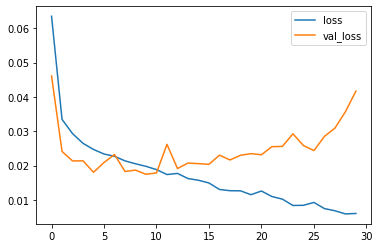

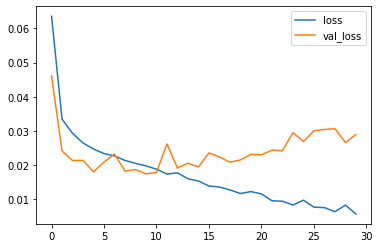

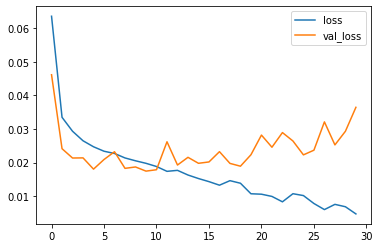

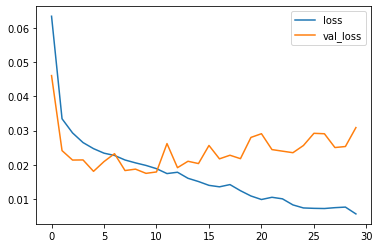

In [36]:
for j in range(n_reruns):
  # Model Creation
  tf.keras.backend.clear_session() 
  tf.keras.utils.set_random_seed(seed)
  #tf.config.experimental.enable_op_determinism()

  model = keras.Sequential()


  if Method=='RNN':
      Layer_type=SimpleRNN
  elif Method=='LSTM':
      Layer_type=LSTM
  elif Method=='GRU':
      Layer_type=GRU

  n_timesteps = X_train_seq.shape[1]

  n_features  = X_train_seq.shape[2]

  input_shape=(n_timesteps,n_features)
  for i in enumerate(neurons):
      if i[0]==len(neurons)-1:
          model.add(Layer_type(units=i[1],input_shape=input_shape,return_sequences=False))   
      else:
          model.add(Layer_type(units=i[1],input_shape=input_shape,return_sequences=True))     

  for i in enumerate(dens_neu):
      model.add(keras.layers.Dense(i[1], activation=act))


  model.add(keras.layers.Dense(1, activation='sigmoid'))


  #Best model so far is here

  #Compile Model
  model.compile(loss=loss, optimizer=Adam(learning_rate=0.001))
  #model.compile(loss=loss, optimizer='adam')
  #Train Model
  print("Training Model no {}".format(j+1))
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
  history = model.fit(verbose = 0,
                          x = X_train_seq,
                          y = y_train_seq,
                          batch_size=batch,
                          epochs=epochs,     
                          validation_split=0.2,
                          #validation_data=(X_valid_seq, y_valid_seq),
                          shuffle=False,
                          validation_steps=None,
                          validation_freq=1,
                          workers=4,
                          use_multiprocessing=False,
                          callbacks=[callback]
                          )

  # print loss curve
  
  history_df = pd.DataFrame(history.history)
  history_df.loc[0:, ['loss', 'val_loss']].plot()
  print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));


  # Save Model
  export_name = 'LSTM_rerun_model_'+str(j+1)
  model.save(export_name)

  # Test Prediction
  # store scores for each model in a dictionary
  y_test_pred=model.predict(X_test_seq).round()
  f1, t_f1, hss, t_hss = errors_classification(y_test_seq, y_test_pred, transitions=True, transition_pos=t_indices_test)
  fm_scores['f1'].append(f1)
  fm_scores['t_f1'].append(t_f1)
  fm_scores['hss'].append(hss)
  fm_scores['t_hss'].append(t_hss)
  
  print("-"*100)
  print()

In [37]:
# save results
with open(os.path.join(path, 'results/lstm_final_scores.pickle'), 'wb') as file:
  pickle.dump(fm_scores, file)

In [39]:
# load in results of LSTM on the unseen test set
with open(os.path.join(path, 'results/lstm_final_scores.pickle'), 'rb') as file:
  fm_scores = pickle.load(file)

In [40]:
performance_report(fm_scores)

Validation Scores
------------------------------
f1
Scores: [37.91821561338289, 41.46341463414634, 42.75862068965516, 41.66666666666667, 40.44943820224719, 37.22627737226277, 40.0, 45.42586750788644, 37.450199203187246, 35.25179856115108]
Mean: 39.961

t_f1
Scores: [26.490066225165563, 28.767123287671236, 29.13907284768212, 30.136986301369863, 28.965517241379313, 35.13513513513514, 26.95035460992907, 33.98692810457516, 24.827586206896548, 26.38888888888889]
Mean: 29.079

hss
Scores: [0.3744, 0.4107, 0.4228, 0.4118, 0.4, 0.3674, 0.3957, 0.4493, 0.3701, 0.3474]
Mean: 0.395

t_hss
Scores: [-0.0673, 0.0, -0.0288, 0.0192, 0.0096, 0.0769, 0.0096, 0.0288, -0.0481, -0.0192]
Mean: -0.002



In [44]:
!pip install -U neptune-client
import neptune.new as neptune

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.8/443.8 KB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 61.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/6

/usr/local/lib/python3.9/dist-packages/neptune/internal/backends/hosted_client.py:48: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
<ipython-input-44-141364a70be9>:2: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


In [46]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/swiatej2/fyp/e/FYP-56/metadata


In [53]:
vars_sel

['vis',
 'temp_dew_dist',
 'rh',
 'ceiling',
 'duration',
 'hsig2',
 'dni',
 'dewpt',
 'drybulb',
 'cbl',
 'hlc',
 'ntot',
 'speed',
 'vp',
 'pchar',
 'dir']

In [54]:
run = neptune.init_run(
    project='swiatej2/fyp',
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjOTQxYjBkZS0zN2Y1LTRhYTQtOGQ1My03YTAxODJkM2E1OWMifQ==',
    name='LSTM',
    description='trained 10 LSTM models with the same parameters and evaluated each on the test set. Computed mean results',

)

performance_report(fm_scores)

run["algorithm"] = 'LSTM'
run["params"] = params
run['features'] = "\n".join(vars_sel)

run['metrics/f1'] = np.round(np.mean(fm_scores['f1']), 2)
run['metrics/transition_f1'] = np.round(np.mean(fm_scores['t_f1']), 2)
run['metrics/hss'] = np.round(np.mean(fm_scores['hss']), 4)
run['metrics/transition_hss'] = np.round(np.mean(fm_scores['t_hss']), 4)


# only include this for compatible models
#run['metrics/pr_auc'] = final_scores['pr_auc']

# save Precision-Recall curve plot
#img_path = os.path.join(path, 'images/xgb_pr_curve.png')
#final_plots['pr_plot'].plot()
#plt.title("Precision-Recall Curve")
#plt.savefig(img_path)

#run['plots/pr_curve'].upload(img_path)

#run['plots/confusion_matrix'] = npt_utils.create_confusion_matrix_chart(final_model, X_train, X_test, y_train, y_test)

run.stop()


https://app.neptune.ai/swiatej2/fyp/e/FYP-62
Validation Scores
------------------------------
f1
Scores: [37.91821561338289, 41.46341463414634, 42.75862068965516, 41.66666666666667, 40.44943820224719, 37.22627737226277, 40.0, 45.42586750788644, 37.450199203187246, 35.25179856115108]
Mean: 39.961

t_f1
Scores: [26.490066225165563, 28.767123287671236, 29.13907284768212, 30.136986301369863, 28.965517241379313, 35.13513513513514, 26.95035460992907, 33.98692810457516, 24.827586206896548, 26.38888888888889]
Mean: 29.079

hss
Scores: [0.3744, 0.4107, 0.4228, 0.4118, 0.4, 0.3674, 0.3957, 0.4493, 0.3701, 0.3474]
Mean: 0.395

t_hss
Scores: [-0.0673, 0.0, -0.0288, 0.0192, 0.0096, 0.0769, 0.0096, 0.0288, -0.0481, -0.0192]
Mean: -0.002

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 13 operations to synchronize with Neptune. Do not kill this process.
All 13 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/